🔍 Running inference on images...
⚠️ Missing label: test1.png
⚠️ Missing label: test10.png
⚠️ Missing label: test11_corrected.png
⚠️ Missing label: test12_corrected.png
⚠️ Missing label: test12_highlighted.png
⚠️ Missing label: test12_result.png
⚠️ Missing label: test13.png
⚠️ Missing label: test13_tested.png
⚠️ Missing label: test14_corrected.png
⚠️ Missing label: test14_corrected_corrected.png
⚠️ Missing label: test15.png
⚠️ Missing label: test16_corrected.png
⚠️ Missing label: test16_tested.png
⚠️ Missing label: test17.png
⚠️ Missing label: test18.png
⚠️ Missing label: test18_corrected.png
⚠️ Missing label: test18_result.png
⚠️ Missing label: test19_tested.png
⚠️ Missing label: test2.png
⚠️ Missing label: test20.png
⚠️ Missing label: test20_corrected.png
⚠️ Missing label: test21.png
⚠️ Missing label: test21_corrected.png
⚠️ Missing label: test22_corrected.png
⚠️ Missing label: test22_corrected_vs_highlighted.png
⚠️ Missing label: test22_highlighted.png
⚠️ Missing label: test22compars

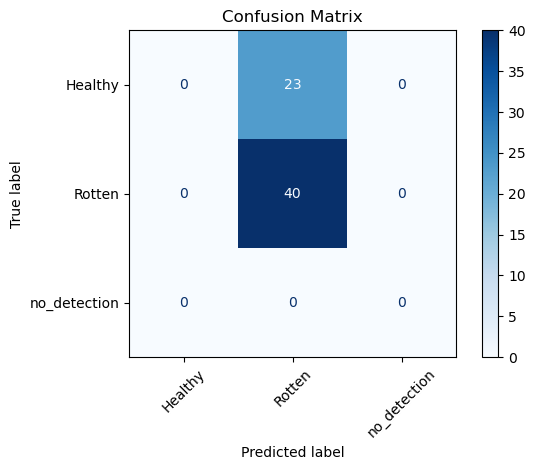

✅ Accuracy: 63.49%
🕒 Evaluation Time: 15.51 seconds


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm import tqdm
import time

# ------------------ Config ------------------
model_path = r"C:\Users\Acer\OneDrive\Documents\final\runs\detect\train\weights\best.pt"
images_dir = r"C:\Users\Acer\OneDrive\Documents\final\test"
labels_dir = r"C:\Users\Acer\OneDrive\Documents\final\test\labels"
class_names = ['Healthy', 'Rotten']
conf_threshold = 0.3
iou_threshold = 0.5
# --------------------------------------------

model = YOLO(model_path)
y_true = []
y_pred = []

detections_by_class = defaultdict(list)
groundtruths_by_class = defaultdict(list)

image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
start = time.time()

print("🔍 Running inference on images...")

for image_file in tqdm(image_files, disable=True):  # Disable the progress bar output
    img_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, os.path.splitext(image_file)[0] + ".txt")
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Suppress the inference logs by setting verbose=False
    results = model.predict(source=img, conf=conf_threshold, iou=0.5, stream=False, verbose=False)
    
    boxes = results[0].boxes
    pred_classes = boxes.cls.cpu().numpy().astype(int) if boxes.cls is not None else []
    pred_confs = boxes.conf.cpu().numpy() if boxes.conf is not None else []
    pred_bboxes = boxes.xyxy.cpu().numpy() if boxes.xyxy is not None else []

    for cls, conf, box in zip(pred_classes, pred_confs, pred_bboxes):
        detections_by_class[cls].append({'image_id': image_file, 'conf': conf, 'box': box.tolist()})

    gt_classes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls_id, x, y, bw, bh = map(float, line.strip().split())
                cls_id = int(cls_id)
                x1 = (x - bw / 2) * w
                y1 = (y - bh / 2) * h
                x2 = (x + bw / 2) * w
                y2 = (y + bh / 2) * h
                gt_box = [x1, y1, x2, y2]
                groundtruths_by_class[cls_id].append({'image_id': image_file, 'box': gt_box, 'used': False})
                gt_classes.append(cls_id)

        # Confusion matrix part
        if len(gt_classes) == 0:
            continue
        if len(pred_classes) == 0:
            for gt in gt_classes:
                y_true.append(gt)
                y_pred.append(len(class_names))  # no detection
        else:
            for gt in gt_classes:
                y_true.append(gt)
                y_pred.append(pred_classes[0])
    else:
        print(f"⚠️ Missing label: {image_file}")

end = time.time()

# ---------------- mAP@0.5 Calculation ----------------

def iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = float(boxAArea + boxBArea - interArea)
    return interArea / union if union > 0 else 0

def compute_ap(recalls, precisions):
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        if np.any(recalls >= t):
            ap += np.max(precisions[recalls >= t])
    return ap / 11

average_precisions = []
for cls_id in range(len(class_names)):
    detections = sorted(detections_by_class[cls_id], key=lambda x: -x['conf'])
    gts = groundtruths_by_class[cls_id]
    for g in gts:
        g['used'] = False

    TP = np.zeros(len(detections))
    FP = np.zeros(len(detections))
    n_gt = len(gts)

    for i, det in enumerate(detections):
        matched = False
        for gt in gts:
            if gt['image_id'] == det['image_id'] and not gt['used']:
                iou_val = iou(det['box'], gt['box'])
                if iou_val >= iou_threshold:
                    TP[i] = 1
                    gt['used'] = True
                    matched = True
                    break
        if not matched:
            FP[i] = 1

    cum_TP = np.cumsum(TP)
    cum_FP = np.cumsum(FP)
    recalls = cum_TP / n_gt if n_gt else np.zeros_like(cum_TP)
    precisions = cum_TP / (cum_TP + cum_FP + 1e-6)
    ap = compute_ap(recalls, precisions)
    average_precisions.append(ap)
    print(f"AP@0.5 for {class_names[cls_id]}: {ap:.4f}")

mAP50 = np.mean(average_precisions)
print(f"\n✅ mAP@0.5: {mAP50:.4f}")

# ---------------- Confusion Matrix ----------------

label_list = class_names + ['no_detection']
y_pred = [p if p < len(class_names) else len(class_names) for p in y_pred]

if len(y_true) == 0:
    print("⚠️ No matched labels! Check label format or filenames.")
else:
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
    disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Accuracy: {acc:.2%}")
    print(f"🕒 Evaluation Time: {end - start:.2f} seconds")